# On The Free Energy Penalty of Cavity Formation In Salt Solutions: Rethinking the Terms “Kosmotropic” and “Chaotropic”.

Stefan Hervø-Hansen<sup>a,*</sup> and Nobuyuki Matubayasi<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.

## Analysis & Model Construction


## Import of Python Modules & Auxiliary Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os,time
import mdtraj as md
import parmed as pmd
import freud

from math import isclose

In [ ]:
salts = {
    # 'NaF': {'cation': 'NA', 'anion': 'F'},
    'NaCl': {'cation': 'NA', 'anion': 'CL'},
    'NaI': {'cation': 'NA', 'anion': 'I'}
}

solutes = {
    'n-butane': {'resname': 'BUT'},
    # 'propane': {'resname': 'PRP'},
}

concentrations = {
#     0.0:{'N_solute':1,'N_water':10000,'N_cation':0,'N_anion':0},
    # 0.25:{'N_solute':1,'N_water':10000,'N_cation':45,'N_anion':45},
    0.5:{'N_solute':1,'N_water':10000,'N_cation':90,'N_anion':90},
#     0.75:{'N_solute':1,'N_water':10000,'N_cation':135,'N_anion':135},
    # 1.00:{'N_solute':1,'N_water':10000,'N_cation':180,'N_anion':180}
}

### Calc RDF

In [ ]:
rdf_script = """#!/bin/bash
#PBS -l nodes=nu:ppn=1

if [ "$PBS_O_WORKDIR" != "" ];then
  cd $PBS_O_WORKDIR
fi
NUMNODES=`wc -l < $PBS_NODEFILE`

source /data2/APPLI/packages/gromacs/gromacs-2021.4-intel-single.rc

cd /home/lin/Cavity-Formation/Simulations/{salt}/{concentration}/rdf

# make index

gmx_mpi make_ndx -f /home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md/solution_run.gro << EOF
q
EOF

# calc cation-water RDF and cn 

gmx_mpi rdf -f /home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md/solution_run.xtc -s /home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md/solution_run.tpr -n index.ndx -cn cn_{cation}_HOH.xvg -o rdf_{cation}_HOH.xvg -rmax 1.5 << EOF
4
2
EOF

# calc anion-water RDF and cn 

gmx_mpi rdf -f /home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md/solution_run.xtc -s /home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md/solution_run.tpr -n index.ndx -cn cn_{anion}_HOH.xvg -o rdf_{anion}_HOH.xvg -rmax 1.5 << EOF
4
3
EOF

DATE=`date`
echo -e '
'$DATE'
endcalc /home/lin/Cavity-Formation/Simulations/{salt}/{concentration}/rdf' >> /home/lin/Cavity-Formation/Reserch_notes.txt
"""

In [ ]:
for salt,S in salts.items():
    for concentration,N in concentrations.items():
        output_dir = f'/home/lin/Cavity-Formation/Simulations/{salt}/{concentration}/rdf'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        os.chdir(f'{output_dir}')
        with open('run.sh', 'w') as f:
            f.write(rdf_script.format(salt=salt,concentration=concentration,cation=S['cation'],anion=S['anion']))
        f.close()
        


NaCl
NaCl
NaI
NaI


Text(0, 0.5, 'Cumulative RDFs')

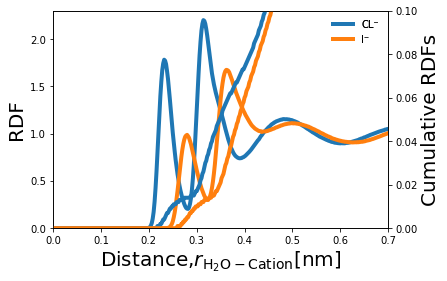

In [42]:
from matplotlib import cm
fig, axes = plt.subplots(1,1,figsize=(6,4))
axes2 = axes.twinx()


for salt,S in salts.items():
    for concentration,N in concentrations.items():
        # plot cation_vs_HOH
        if S['cation']+S['anion'] in ['NAF','NACL','NAI']:
            x, y = [], []
            print (salt)
            anion = S['anion']
            with open(f"/home/lin/Cavity-Formation/Simulations/{salt}/{concentration}/rdf/rdf_{anion}_HOH.xvg") as f:
                for line in f:
                    if line[0] == '#' or line[0] == '@':
                        continue
                    else:
                        cols = line.split()
                        x.append(float(cols[0]))
                        y.append(float(cols[1]))
            axes.plot(x,y,label=S['anion']+'⁻', linewidth=4)
        if S['cation']+S['anion'] in ['NAF','NACL','NAI']:
            p, q = [], []
            print (salt)
            anion = S['anion']
            with open(f"/home/lin/Cavity-Formation/Simulations/{salt}/{concentration}/rdf/cn_{anion}_HOH.xvg") as f:
                for line in f:
                    if line[0] == '#' or line[0] == '@':
                        continue
                    else:
                        cols = line.split()
                        p.append(float(cols[0]))
                        q.append(float(cols[1]))
            axes2.plot(p,q,label=S['anion']+'⁻', linewidth=4)
      



axes.legend(frameon=False)
axes.set_xlim(0,0.7)
axes.set_ylim(0,2.3)
axes.set_xlabel(r'Distance,$r_{\mathrm{H_2O - Cation}}$[nm]',fontsize=20)
axes.set_ylabel('RDF',fontsize=20)

axes2.legend(frameon=False)
axes2.set_xlim(0,0.7)
axes2.set_ylim(0,0.1)
axes2.set_ylabel('Cumulative RDFs',fontsize=20)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(13,10))
mddir = '/data4/lin/Cavity-Formation/md'

i = True
for salt,S in salts.items():
    for concentration,N in concentrations.items():
        output_dir = f'/home/lin/Cavity-Formation/Simulations/salt_water/{salt}/{concentration}'
        md_dir = f'/home/lin/Cavity-Formation/md/salt_water/{salt}/{concentration}/md'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)


        os.chdir(f'{md_dir}')
        traj = md.load_xtc(f'solution_run.xtc',top=f'solution_run.gro')

        # for water-cation
        pairs = traj.topology.select_pairs(selection1="resname NA",selection2="resname HOH")
        rdf = md.compute_rdf(traj,pairs,r_range=(0.0, 0.7))
        print('finshed conpute rdf')
        # with open('rdf_output','w') as rdf_output:
        #     rdf_output.write(str(rdf))
        axes[0].legend(frameon=False)
        axes[0].plot(rdf[0],rdf[1],linewidth=2,label=S['anion'])
        # i = False

        # for water-anion
        pairs = traj.topology.select_pairs(selection1="resname {}".format(S['anion']),selection2="resname HOH")
        rdf = md.compute_rdf(traj,pairs,r_range=(0.0, 0.7))
        print('finshed conpute rdf')
        # with open('rdf_output','w') as rdf_output:
        #     rdf_output.write(str(rdf))
        axes[1].legend(frameon=False)
        axes[1].plot(rdf[0],rdf[1],linewidth=2,label=S['anion'])

fig.savefig('/home/lin/data/test/RDF_output2.eps')
            
        

            


### ERmod

In [ ]:
homedir = '/home/lin'
mddir = '/data4/lin/Cavity-Formation/md'
outputdir = '/data4/lin/Cavity-Formation/Simulations'


In [ ]:
ermod_script = """#!/bin/bash
#PBS -l nodes=1:nu:ppn=18

if [ "$PBS_O_WORKDIR" != "" ];then
  cd $PBS_O_WORKDIR
fi
NUMNODES=`wc -l < $PBS_NODEFILE`

# source /data2/APPLI/packages/gromacs/gromacs-2020.6-intel-double.
# source /data2/APPLI/packages/ermod-0.3.7/ermod-intel.rc GROMACS

gen_structure -t {top_dir}/topol.top -s {resname}

cd soln

gen_input -x {solution_traj} -l {solution_log}
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

cd ../refs

gen_input -x {refs_traj} -l {refs_log} -s {solute_traj}
mpirun -machinefile $PBS_NODEFILE -np $NUMNODES ermod

cd ..

mpirun -machinefile $PBS_NODEFILE -np $NUMNODES slvfe > free_energy.txt
"""

In [ ]:
for solute,L in solutes.items():
    top_dir = f'{mddir}/solute_water/{solute}/solution/sys'
    solution_dir = f'{mddir}/solute_water/{solute}/solution/md'
    refs_dir = f'{mddir}/pure_water/10_md'
    solute_dir = f'{mddir}/solute_water/{solute}/solute/md/solute_run.xtc'

    solution_traj = f'{solution_dir}/solution_run.xtc'
    solution_log = f'{solution_dir}/solution_run.log'
    refs_traj = f'{refs_dir}/solution_run.xtc'
    refs_log = f'{refs_dir}/solution_run.log'
    solute_traj = f'{solute_dir}/solute_run.xtc'

    output_dir = '/data4/lin/Cavity-Formation/Simulations'

    %cd {output_dir}/nosalt
    with open('ermod.sh', 'w') as f:
        f.write(ermod_script.format(top_dir=top_dir,solution_traj=solution_traj,solution_log=solution_log,refs_traj=refs_traj,refs_log=refs_log,solute_traj=solute_dir,resname=L['resname']))
    f.close()
    # !qsub ermod.sh

    for salt,S in salts.items():
        for concentration,N in concentrations.items():
            top_dir = f'{mddir}/solute_salt_water/{solute}/{salt}/{concentration}/sys'
            solution_dir = f'{mddir}/solute_salt_water/{solute}/{salt}/{concentration}/md'
            refs_dir = f'{mddir}/salt_water/{salt}/{concentration}/md'
            solute_dir = f'{mddir}/solute_water/{solute}/solute/md'

            solution_traj = f'{solution_dir}/solution_run.xtc'
            solution_log = f'{solution_dir}/solution_run.log'
            refs_traj = f'{refs_dir}/salt_water_run.xtc'
            refs_log = f'{refs_dir}/salt_water_run.log'
            solute_traj = f'{solute_dir}/solute_run.xtc'

            %cd {outputdir}/{salt}/{concentration}
            with open('ermod.sh', 'w') as f:
                f.write(ermod_script.format(top_dir=top_dir,solution_traj=solution_traj,solution_log=solution_log,refs_traj=refs_traj,refs_log=refs_log,solute_traj=solute_traj,resname=L['resname']))
            f.close()
            # !qsub ermod.sh
            

In [ ]:
def MC_CalcVolume(traj, top, Niterations, molecule_box_ratio=0, blockaverages=None, debugging=False):
    """
    Computes the molecular volume by the usage of a Hit & Miss Monte Carlo algorithm.

    This function simply wraps the ``+`` operator, and does not
    do anything interesting, except for illustrating what
    the docstring of a very simple function looks like.

    Parameters
    ----------
    traj : MDTraj trajectory
        MD/MC trajectory loaded using the MD traj library.
    top : parmed topology
        topology containing the LJ parameters for all particles in the trajectory.
    molecule_box_ratio: float, default=0
        Extra lengths added to box enclosing molecule.
    blockaverages: int>1 or None, default=None
        Computation of N>1 bloc kaverages, if None this is skipped.
    debugging: bool, defualt=False
        Returning volume of molecule, volume of box, and Hit&Miss ratio. 
    
    Returns
    -------
    np.array
        The volumes of the molecules for the various frames.
        If debugging == True, the volumes are followed by the box volume and Hit&Miss ratio for the last frame.
    """
    
    # Find all radii for solute molecule
    atomic_radii = np.empty(shape=(traj.n_atoms)) # In nanometer
    for atom in top.atoms:
        atomic_radii[atom.idx] = 0.5*atom.sigma   # In Ångstrom
        atomic_radii[atom.idx] /= 10              # Convert to nanometer
        
    # Initialize data collection and block averages
    if blockaverages:
        if blockaverages < 2:
            raise Exception('blockaverages must be larger or equal to 2 or None.')
        if not isinstance(blockaverages, int):
            raise Exception('blockaverages must be an int.')
        Vdata = np.zeros(shape=(traj.n_frames, blockaverages))
    else:
        Vdata = np.zeros(shape=(traj.n_frames))
    
    
    for frameNr, frame in enumerate(traj): # Trajectory loop
        # Find min/max molecule dimensions and from there box dimensions
        molecule_dimensions = np.zeros(shape=(2,3))
        for i in range(molecule_dimensions.shape[0]):
            for j in range(molecule_dimensions.shape[1]):
                if i == 0:
                    molecule_dimensions[i][j] = np.min(frame.xyz[0][:,j] - atomic_radii)
                else:
                    molecule_dimensions[i][j] = np.max(frame.xyz[0][:,j] + atomic_radii)
        box_dimensions = molecule_dimensions + molecule_dimensions * molecule_box_ratio
        
        # Calculate box volume
        Vbox = (np.linalg.norm(box_dimensions[0][0] - box_dimensions[1][0])* # x
                np.linalg.norm(box_dimensions[0][1] - box_dimensions[1][1])* # y
                np.linalg.norm(box_dimensions[0][2] - box_dimensions[1][2])) # z
        
        if not blockaverages:
            Nblockaverages = 1
        else:
            Nblockaverages = blockaverages
            
        for blockaverage in range(Nblockaverages): # Block average loop
            Nhits = 0
            for i in range(Niterations): # MC loop
                # Generate random point
                point = np.array([np.random.uniform(box_dimensions[0][0], box_dimensions[1][0]),  # x
                                  np.random.uniform(box_dimensions[0][1], box_dimensions[1][1]),  # y
                                  np.random.uniform(box_dimensions[0][2], box_dimensions[1][2])]) # z
                
                # Check if point is found within the vdw spheres of particles
                for atom_idx, atom_coordinate in enumerate(frame.xyz[0]): # Particle loop
                    atom_radius = atomic_radii[atom_idx]
                    distance = np.linalg.norm(atom_coordinate - point)
                    if distance <= atom_radius:
                        Nhits += 1
                        break
                        
            # Calculate the volume: V = n_hit / n_total * V_box
            if blockaverages:
                Vdata[frameNr, blockaverage] = Nhits / Niterations * Vbox
            else:
                Vdata[frameNr] = Nhits / Niterations * Vbox
    
    if debugging:
        return Vdata, Vbox, Nhits/Niterations
    else:
        return Vdata

In [ ]:
# TESTING ALGORITHM #
# The MC algorithm is tested on water that only possess LJ parameters for oyxgen thus being a spherical particle.
# The analytical solutions for r being the radius of the sphere:
# Volume of sphere: 4/3*π*r^3
# Volume of box inscribing sphere: (2*r)^3
# Ratio of box volume to sphere volume: 6/π.

topology = pmd.load_file('Force_fields/OPC.itp', xyz='PDB_files/OPC.pdb')
water_pdb = md.load_pdb('PDB_files/OPC.pdb')
water_radius = topology.atoms[0].sigma*0.5*0.1 # in nanometer
V_molecule_analytical = 4/3*np.pi*water_radius**3
V_box_analytical = (2*water_radius)**3
ratio = np.pi/6
Vmolecule, Vbox, sampled_ratio = MC_CalcVolume(water_pdb, topology, Niterations=1000000, blockaverages=None, debugging=True)

assert isclose(V_molecule_analytical, Vmolecule[0], rel_tol=1e-3), 'Molecular volume is not within the tolerance.'
assert isclose(V_box_analytical, Vbox, rel_tol=1e-7), 'Box volume is not within tolerance.'
assert isclose(ratio, sampled_ratio, rel_tol=1e-3), 'Box volume to spherical volume is not within tolerance.'

In [ ]:

%cd /home/lin/data/ermod/ethanol/solution/md

traj = md.load_xtc('solution_run.xtc',top='solution_run.gro')
pairs = traj.topology.select_pairs(selection1="water",selection2="water")
rdf = md.compute_rdf(traj,pairs)


# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4*2.1))
# axes[0][1].plot(rdf[0], rdf[1], label='hoge', linewidth=4)
fig, axe= plt.subplots()
axe.set_ylabel('RDF')
axe.set_xlabel('nm')
plt.plot(rdf[0], rdf[1], label='hoge', linewidth=1)

# plt.savefig("test.eps")


# RESEARCH NOTES
_will be deleted when the study is finished_